In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain
from exp_hp import get_hp

2024-08-05 15:22:35.457030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


### Load standardized E3SM

In [3]:
%%time
EXP_NAME = 'exp1'
EXP_NAME2 = 'exp1_retrain'
hps = get_hp(EXP_NAME)
hps2 = get_hp(EXP_NAME2)

print('Training Members: '+str(hps2['train_mems']))
print('Validation Member: '+str(hps2['val_mems'][0]))
print('Testing Member: '+str(hps2['test_mems'][0]))
print('Lead: '+str(hps2['LEAD']))
print('Region: '+str(hps2['region'][0])+'N x '+str(hps2['region'][1])+'E')

_, _, X1test, _, _, Y1test,_ = split_retrain(trainmems = hps2['train_mems'],
                                                  valmem = hps2['val_mems'][0],
                                                  testmem = hps2['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps2['LEAD'])

X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))

#----- SET UP & TRAIN NN -----
GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving
CPU times: user 13.3 s, sys: 2.74 s, total: 16.1 s
Wall time: 17.1 s


0


2024-08-05 15:22:54.155444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


240/240 [==============================] - 0s 693us/step
1
240/240 [==============================] - 0s 694us/step
2
240/240 [==============================] - 0s 687us/step
3
240/240 [==============================] - 0s 689us/step
4
240/240 [==============================] - 0s 766us/step
5
240/240 [==============================] - 0s 954us/step
6
240/240 [==============================] - 0s 961us/step
7
240/240 [==============================] - 0s 682us/step
8
240/240 [==============================] - 0s 683us/step
9
240/240 [==============================] - 0s 686us/step


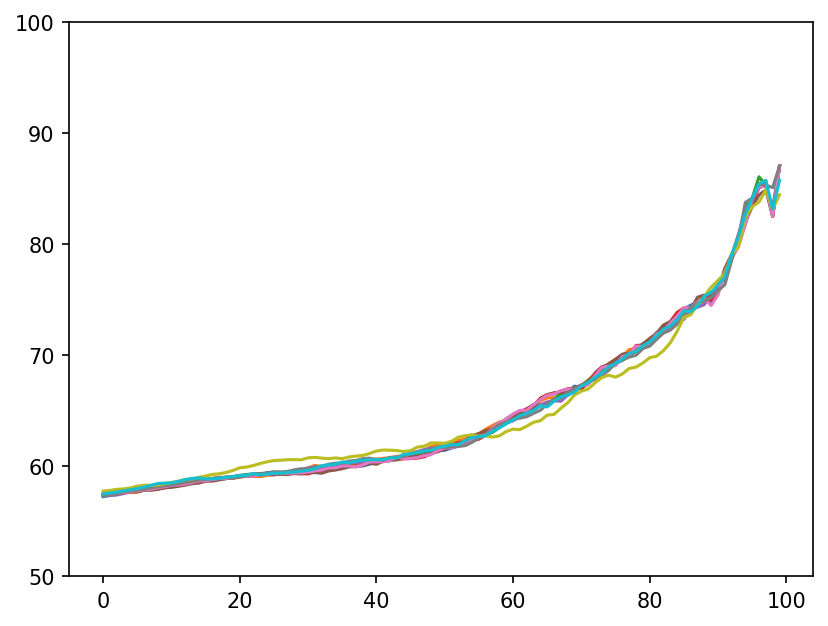

In [4]:
acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann2_60Eshift_'+EXP_NAME2+'.8_ann1-'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)

    pred = ann.predict(X1test)
    acc = []
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    for q in range(100):
        iconf = np.where(predconf >= np.percentile(predconf,q=q))
        icorr = np.where(predval[iconf] == Y1test[iconf])

        acc.append((len(icorr[0])/len(iconf[0]))*100)
    plt.plot(acc)
    plt.ylim(50,100)

    acc_all.append(acc)
plt.show()
np.save(base_dir+'test/confvsacc/confvsacc_ann2_60Eshift_'+EXP_NAME2+'.8_ann1-'+EXP_NAME+'.npy', acc_all, allow_pickle=True)